# Kernel methods for a 1 dimensional elliptic PDE

Here we will solve the PDE

$$\begin{cases} C_1 u^3 + C_2 \Delta u = f, & x \in [0,1] \\ u = 0, &x \in \partial [0,1]^d \end{cases}$$

where $\Delta$ is the Laplacian.

In [1]:
import qmcpy as qp 
import numpy as np 
import torch
import time
from collections import OrderedDict

In [2]:
from matplotlib import pyplot,cm,colors,gridspec
pyplot.style.use('seaborn-whitegrid')
LW = 3 # linewidth

## Reference Solution

$$u(x) = \exp\left(-\frac{1}{1-r^2}\right)\left[\sin(\pi x)+\frac{1}{2}\sin(4\pi x)\right] 1_{x \in (0,1)}$$

where $r = 2x-1$.

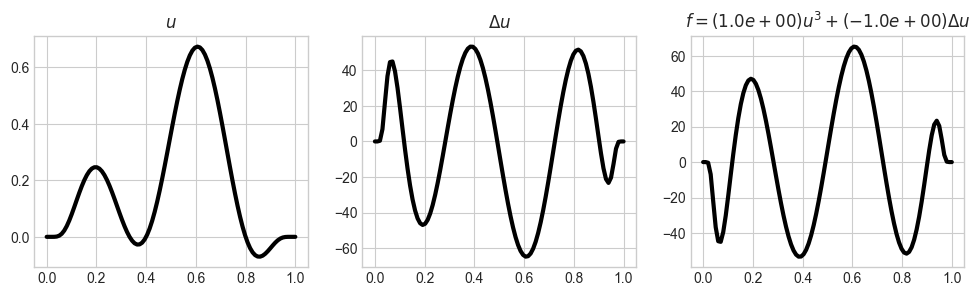

In [3]:
C1 = 1.
C2 = -1.
def u(x):
    y = torch.zeros_like(x)
    r = 2*x-1
    b = torch.abs(r)<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = torch.sin(torch.pi*x[b])
    t3 = torch.sin(4*torch.pi*x[b])
    y[b] = t1*(t2+t3)
    return y
def u_laplace(x):
    xg = x.clone().requires_grad_()
    yg = u(xg)
    grad_outputs = torch.ones_like(x)
    ypg = torch.autograd.grad(yg,xg,grad_outputs,create_graph=True)[0]
    yppg = torch.autograd.grad(ypg,xg,grad_outputs,create_graph=True)[0]
    return yppg.detach()
def f(x):
    return C1*u(x)**3+C2*u_laplace(x)
xticks = torch.linspace(0,1,100,dtype=float)
yticks = u(xticks) 
ylticks = u_laplace(xticks)
fticks = f(xticks)
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,3))
ax[0].plot(xticks,yticks,color='k',linewidth=LW)
ax[1].plot(xticks,ylticks,color='k',linewidth=LW)
ax[2].plot(xticks,fticks,color='k',linewidth=LW)
ax[0].set_title(r"$u$")
ax[1].set_title(r"$\Delta u$")
ax[2].set_title(r"$f = (%.1e) u^3 + (%.1e) \Delta u$"%(C1,C2));

## PDE Setup

In [4]:
ns = torch.tensor([ # number of collocation points
    2**10, #  on the interior
    1 # on the boundary
],dtype=int)
us = torch.tensor([ # dimensions not projected to the 0 boundary
    [True], # interior points (not projected to the 0 boundary)
    [False] # boundary points (projected to the 0 boundary) 
],dtype=bool) 
llbetas = [ # derivative orders 
    [ # interior
        torch.tensor([[0]],dtype=int), # u
        torch.tensor([[2]],dtype=int), # laplacian u  
    ],
    [ # boundary
        torch.tensor([[0]],dtype=int) # u
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # u 
        torch.ones(1,dtype=float) # laplacian u
    ],
    [ # boundary
        torch.ones(1,dtype=float) # u
    ]
]

In [5]:
def pde_lhs(ly_i, ly_b):
    u_i,u_laplace_i = ly_i
    u_b = ly_b[0] 
    lhs_i = C1*u_i**3+C2*u_laplace_i
    lhs_b = u_b
    return lhs_i,lhs_b
def pde_rhs(x_i, x_b):
    y_i = f(x_i[:,0])
    y_b = torch.zeros(len(x_b),dtype=float)
    return y_i,y_b

## Kernel Interpolant 

### Construction

In [6]:
noise = 1e-8
lattice = qp.Lattice(dimension=1,seed=7) # collocation points
kernel = qp.KernelShiftInvar(dimension=1,lengthscales=1e-1,alpha=4,scale=1.,torchify=True) # kernel
ki = qp.FastPDEGramMatrix(kernel,lattice,ns,us,llbetas,llcs,noise) # kernel interpolant

### PDE Optimization

In [9]:
y,data = ki.pde_opt_gauss_newton(
    pde_lhs = pde_lhs,
    pde_rhs = pde_rhs,
    maxiter = 8,
    verbose = True)

    iter (8 max)   loss           
    0              3.63e+01       
    1              9.91e-02       
    2              1.18e-05       
    3              3.01e-10       
    4              9.41e-12       
    5              9.43e-12       
    6              9.56e-12       
    7              9.39e-12       
    8              9.55e-12       


### Fitting

In [19]:
#coeffs = ki._solve(y) 
coeffs,pcg_data = qp.kernel_methods.pcg(ki,y)
kvec = ki.get_new_left_full_gram_matrix(xticks[:,None])
yhat = kvec@coeffs
print("fhat_gauss.shape = %s"%yhat.shape)
print("L2 Rel Error Gauss: %.1e"%(torch.linalg.norm(yhat-yticks)/torch.linalg.norm(yticks)))

fhat_gauss.shape = 100
L2 Rel Error Gauss: 1.5e-07


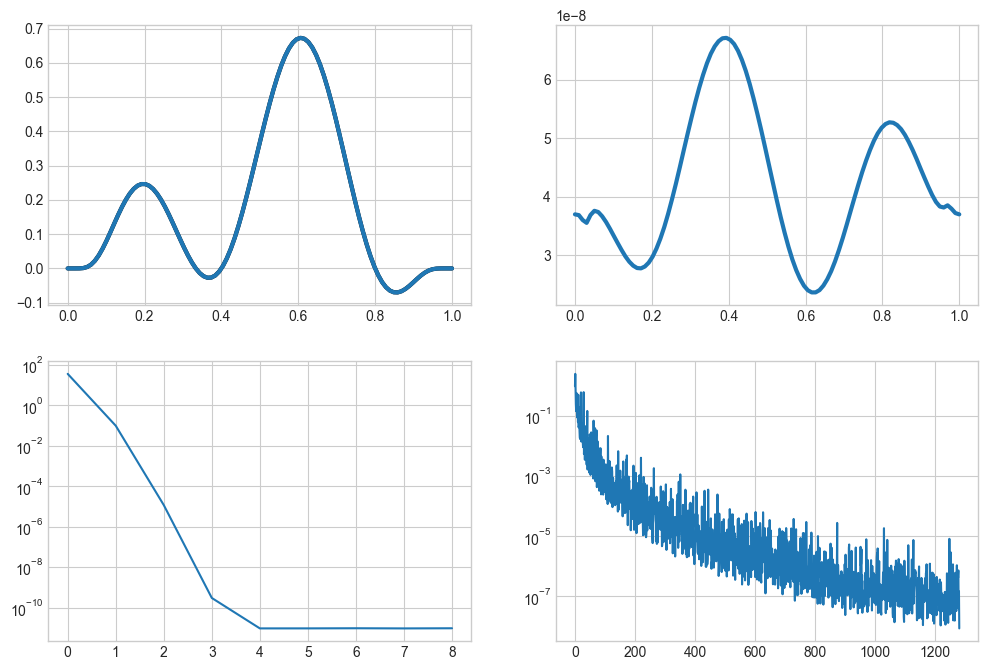

In [20]:
fig,ax = pyplot.subplots(nrows=2,ncols=2,figsize=(12,8))
ax[0,0].plot(xticks,yticks,color="k",linewidth=LW)
ax[0,0].plot(xticks,yhat,linewidth=LW)
ax[0,1].plot(xticks,torch.abs(yhat-yticks),linewidth=LW)
ax[1,0].plot(torch.arange(len(data["losses"])),data["losses"])
ax[1,0].set_yscale("log",base=10)
ax[1,1].plot(torch.arange(len(pcg_data["rbackward_norms"])),pcg_data["rbackward_norms"])
ax[1,1].set_yscale("log",base=10)